In [57]:
#Importamos librerias
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd        
import seaborn as sns
import keras #Wrapper de tensorflow (pytorch)
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import recall_score
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from keras.models import Sequential
from keras.layers import Dense #Full-connected
from yellowbrick.cluster import KElbowVisualizer
import warnings
import plotly as py
import plotly.io as pio
import plotly.express as px
from imblearn.combine import SMOTETomek
%matplotlib inline     
sns.set(color_codes=True)

In [58]:
#Cargamos el CSV
df = pd.read_csv('emisiones_co2.csv')

In [60]:
def ValidaNormativa(intCO2Vehiculo):
    intcumple = 0
    intCE02Norma=df["CO2"].median()
    if (intCO2Vehiculo<=intCE02Norma):
        intcumple=1
    else:
        intcumple=0
    return intcumple


In [61]:
#Agregamos la nueva columna para validar si cumple la normativa esperada
#Remplazamos peso en blanco por mediana

df['Volume']=df['Volume'].replace(0,df['Volume'].median())

df["CumpleNormativa"] =df.apply(lambda x: ValidaNormativa(x["CO2"]),axis=1)



In [68]:
df['CumpleNormativa'].value_counts()

1    970
0    784
Name: CumpleNormativa, dtype: int64

<AxesSubplot:xlabel='Volume'>

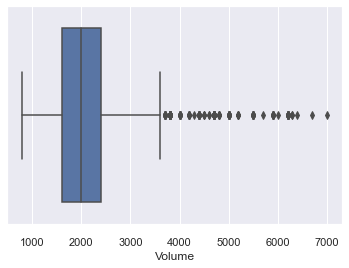

In [63]:
#Revisión outliner
sns.boxplot(x=df['Volume'])

<AxesSubplot:xlabel='Weight'>

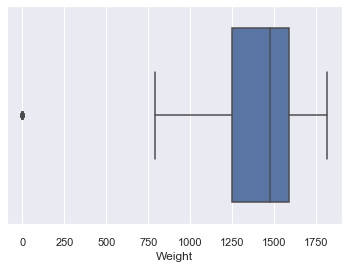

In [64]:
#Revisión outliner
sns.boxplot(x=df['Weight'])

<AxesSubplot:xlabel='CO2'>

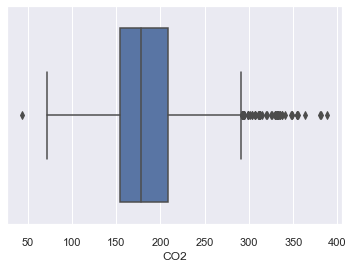

In [65]:
#Revisión outliner
sns.boxplot(x=df['CO2'])  

In [66]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1
print(IQR)

Volume             800.0
Weight             341.0
CO2                 55.0
CumpleNormativa      1.0
dtype: float64


In [67]:
df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]
df.shape

C:\Users\Eric Hutchinson\AppData\Local\Temp\ipykernel_3528\4147643536.py:1: FutureWarning: Automatic reindexing on DataFrame vs Series comparisons is deprecated and will raise ValueError in a future version. Do `left, right = left.align(right, axis=1, copy=False)` before e.g. `left == right`
  df = df[~((df < (Q1 - 1.5 * IQR)) |(df > (Q3 + 1.5 * IQR))).any(axis=1)]


(1754, 6)

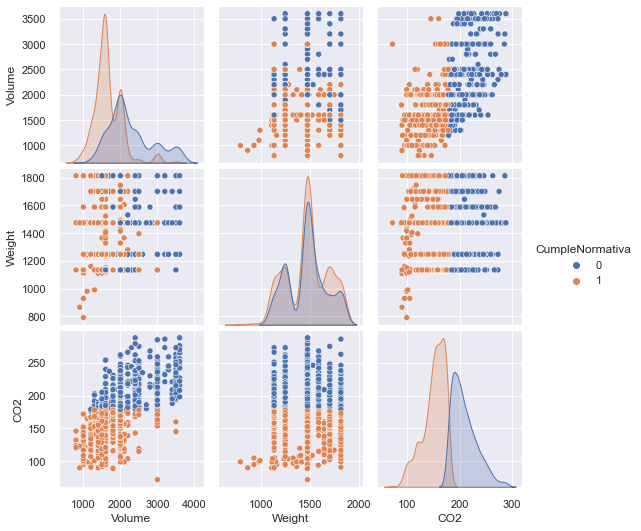

In [88]:
#sns.barplot(x="Car", y="CumpleNormativa", data=df)
sns.pairplot(df,hue="CumpleNormativa")

In [ ]:
X = df.iloc[:, 0:5].values #Primera columnas, no consideramos si cumple normativa o no
y = df.iloc[:, 5].values #Ultima columna para ver si cumple normativa
Le_Car = LabelEncoder()
X[:, 0] = Le_Car.fit_transform(X[:, 0])
Le_Model = LabelEncoder()
X[:, 1] = Le_Model.fit_transform(X[:, 1])
# ohe = OneHotEncoder(categorical_features=[1])
# X = ohe.fit_transform(X).toarray()
# # evitar trampa de variable irrrelevante ;)
# X = X[:, 1:]


In [89]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [90]:
sc = StandardScaler() #normalizacion Z
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)
#print(X_train)

In [71]:
knn=KNeighborsClassifier(n_neighbors=7)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=7)

In [91]:
confusion_matrix(y_test, knn.predict(X_test))

array([[156,   8],
       [  8, 179]], dtype=int64)

In [73]:
smt = SMOTETomek(sampling_strategy='auto', random_state=105)
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)

In [74]:
svc=SVC(probability=True)

svc.fit(X_train_smt, y_train_smt)

SVC(probability=True)

In [75]:
print ('Accuracy (dataset desbalanceado): {:2.2%}'.format(accuracy_score(y_test, knn.predict(X_test))))
print ('Accuracy (dataset balanceado): {:2.2%}'.format(accuracy_score(y_test, svc.predict(X_test))))

Accuracy (dataset desbalanceado): 95.44%
Accuracy (dataset balanceado): 97.72%


In [76]:

print ('Sensitividad: {:2.2%}'.format(recall_score(y_test, svc.predict(X_test))))


Sensitividad: 98.40%


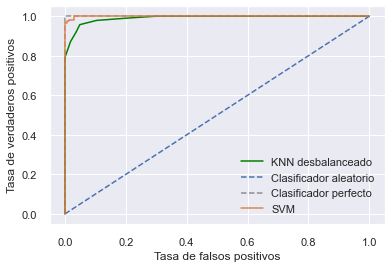

In [77]:


auc_svc = roc_auc_score(y_test, svc.predict_proba(X_test)[:,1])
fpr_svc, tpr_svc, _ = roc_curve(y_test,  svc.predict_proba(X_test)[:,1])

random_probs = [0 for _ in range(len(y_test))]
auc_random = roc_auc_score(y_test, random_probs)
fpr_rn, tpr_rn, _ = roc_curve(y_test, random_probs)

auc_knn = roc_auc_score(y_test, knn.predict_proba(X_test)[:,1])
fpr_knn, tpr_knn, _ = roc_curve(y_test,  knn.predict_proba(X_test)[:,1])

auc_perfect = roc_auc_score(y_test, y_test)
fpr_pr, tpr_pr, _ = roc_curve(y_test, y_test)

plt.plot(fpr_knn,tpr_knn,label="KNN desbalanceado", color='green')
plt.plot(fpr_rn, tpr_rn, linestyle='--', label='Clasificador aleatorio')
plt.plot(fpr_pr, tpr_pr, linestyle='--',color='black', alpha=0.4, label='Clasificador perfecto')
plt.plot(fpr_svc,tpr_svc,label="SVM")
plt.ylabel('Tasa de verdaderos positivos')
plt.xlabel('Tasa de falsos positivos')
plt.legend(loc="lower right")
plt.show()

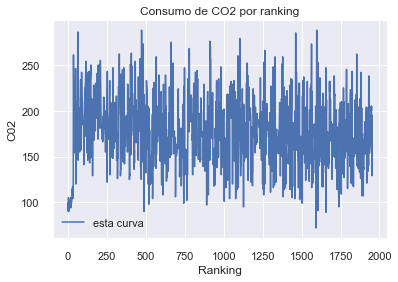

In [78]:
# Visualización de gráficas

df['CO2'].astype(float).plot()
plt.grid(True)
plt.xlabel("Ranking")
plt.ylabel("C02")
plt.title("Consumo de CO2 por ranking")
plt.legend(["esta curva"])

(array([1, 2]), [Text(1, 0, 'Volume'), Text(2, 0, 'Weight')])

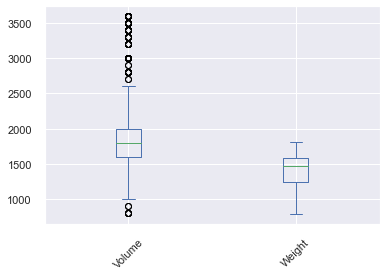

In [79]:
df_sin_varios = df.loc[:, ~df.columns.isin(['Car', 'Model', 'CO2','CumpleNormativa'])]
df_sin_varios.astype(float).plot(kind="box")
plt.xticks(rotation=45)

Text(0.5, 0.98, 'muchos histogramas')

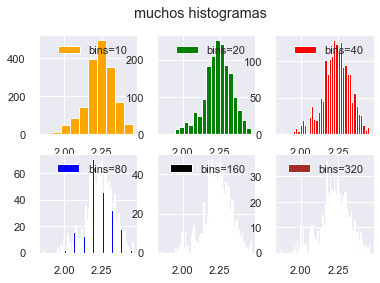

In [80]:
filas = 2
columnas = 3
cajitas = 10
contador = 0
colores = ['orange', 'green', 'red', 'blue', 'black', 'brown']
fig, axs = plt.subplots(filas, columnas)
for fil in range(filas):
  for col in range(columnas):
    axs[fil, col].hist(np.log10(df['CO2'].astype(float).values), bins=cajitas, color=colores[contador])
    axs[fil, col].legend(["bins=" + str(cajitas)])
    cajitas *= 2
    contador += 1
fig.suptitle("muchos histogramas")

In [ ]:
enc = LabelEncoder()
temp = df.copy()
temp.iloc[:, 0]=enc.fit_transform(df.iloc[:, 0])
temp.iloc[:, 1]=enc.fit_transform(df.iloc[:, 1])
temp.head()

In [ ]:
#Regresion Lineal
target = temp[['CO2']].copy()
x2=temp[temp.columns[0:6]]

y2 = target["CO2"]
print(x2.shape)

In [ ]:
lm = linear_model.LinearRegression()
model = lm.fit(x2,y2)

In [ ]:
predictions = lm.predict(x2)
print(predictions[0:10])

In [ ]:
lm.score(x2,y2)

In [ ]:
lm.coef_

In [ ]:
lm.intercept_

In [ ]:
#temp.head()

plt.style.use('fivethirtyeight')
plt.figure(1 , figsize = (15 , 6))
n = 0 
for x in ['Volume' , 'Weight' , 'CO2']:
    n += 1
    plt.subplot(1 , 3 , n)
    plt.subplots_adjust(hspace =0.5 , wspace = 0.5)
    sns.distplot(df[x] , bins = 20)
    plt.title('Distplot of {}'.format(x))

In [ ]:
df.corr()

In [ ]:
#https://www.themachinelearners.com/k-means/
X1 = preprocessing.normalize(temp)
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,12))
visualizer.fit(X1)        # Entrenamos con los datos
visualizer.show()        # Renderizamos la imagen

In [ ]:
algorithm = KMeans(n_clusters = 4 ,init='k-means++', n_init = 10 ,max_iter=300, 
                        tol=0.0001,  random_state= 111  , algorithm='elkan')
algorithm.fit(X1)
labels = algorithm.labels_
centroids = algorithm.cluster_centers_
df['label'] =  labels

In [ ]:
y_kmeans= algorithm.predict(X1)

In [ ]:
plt.scatter(X[:, 0], X[:, 1], c=y_kmeans, s=50, cmap='rainbow');

In [ ]:
fig = px.scatter_3d(df, x='Volume', y='CO2', z='Weight',
              color='label')
fig.show()
